In [1]:
from preprocessing_utils import *
import os
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F

In [3]:
df_stats = get_game_data()
Y = df_stats['Team1 result']
labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(Y)

df_stats = df_stats.loc[:, df_stats.columns.str.contains('Norm')]

In [4]:
df_stats.columns

Index(['W-L% Norm Diff', 'SOS Norm Diff', 'ORtg Norm Diff', 'DRtg Norm Diff',
       'FG% Norm Diff', 'Seed Norm Diff', 'WL% * SOS Norm Diff',
       '3P% Norm Diff', 'FT% Norm Diff', 'PPG Norm Diff', 'OPPG Norm Diff',
       'APG Norm Diff', 'TOVPG Norm Diff', 'Adjusted WL% Norm Diff',
       'Adjusted Margin Norm Diff'],
      dtype='object')

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(df_stats, Y, test_size=0.25, random_state=101 )

pca = PCA(0.99)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

X_train = pd.DataFrame(data = X_train, columns = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11', 'PC12'])
X_train = X_train.values

In [83]:
class Network(nn.Module):
    def __init__(self, isTraining = True):
        super().__init__()
        
        nfeatures = 12
        self.isTraining = isTraining
        self.input = nn.Linear(nfeatures, 256)
        self.hidden1 = nn.Linear(256, 256)
        self.output = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        x = F.dropout(x, p = 0.7, training=self.isTraining)
        x = self.hidden1(x)
        x = F.relu(x)
        x = F.dropout(x, p = 0.7, training=self.isTraining)
        x = self.output(x)
        x = self.sigmoid(x)
        
        return x

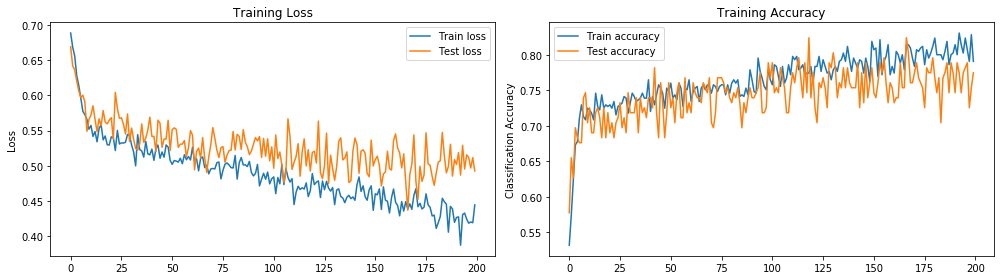

Train Accuracy 0.8306


In [84]:
model = Network(isTraining=True)

loss_func = nn.BCELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
iters = 200
Y_train_t = torch.FloatTensor(Y_train).reshape(-1, 1)
Y_test_t = torch.FloatTensor(Y_test).reshape(-1, 1)
for i in range(iters):
    X_train_t = torch.FloatTensor(X_train)
    y_hat = model(X_train_t)
    loss = loss_func(y_hat, Y_train_t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    y_hat_class = np.where(y_hat.detach().numpy()<0.5, 0, 1)
    accuracy = np.sum(Y_train.reshape(-1,1)==y_hat_class) / len(Y_train)
    train_accuracy.append(accuracy)
    train_loss.append(loss.item())
    
    X_test_t = torch.FloatTensor(X_test)
    y_hat = model(X_test_t)
    loss = loss_func(y_hat, Y_test_t)
    y_hat_class = np.where(y_hat.detach().numpy()<0.5, 0, 1)
    accuracy = np.sum(Y_test.reshape(-1,1)==y_hat_class) / len(Y_test)
    test_accuracy.append(accuracy)
    test_loss.append(loss.item())
    
fig, ax = plt.subplots(1, 2, figsize=(14,4))
ax[0].plot(train_loss, label='Train loss')
ax[0].plot(test_loss, label='Test loss')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')
ax[0].legend()

ax[1].plot(train_accuracy, label='Train accuracy')
ax[1].plot(test_accuracy, label='Test accuracy')
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()
print("Train Accuracy {:.4f}".format(max(train_accuracy)))

In [85]:
model.isTraining = False
X_test_t = torch.FloatTensor(X_test)
y_hat_test = model(X_test_t)
y_hat_test_class = np.where(y_hat_test.detach().numpy()<0.5, 0, 1)
test_accuracy = np.sum(Y_test.reshape(-1,1)==y_hat_test_class) / len(Y_test)
print("Test Accuracy {:.2f}".format(test_accuracy))

Test Accuracy 0.78


In [81]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, y_hat_test_class)

array([[62, 14],
       [16, 50]])